In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import pyodbc
from sklearn.base import BaseEstimator, TransformerMixin
from lib.data_preprocessing_lib import ConvertMinutesToHours, DeriveFeatures, MapIndustrySector, ColumnSelector
from lib.data_preprocessing_lib import WorkingBehaviorCategorization, ZTestAnomaly, FuelAnomalyDetection
from lib.data_preprocessing_lib import EnsureDataTypes
from lib.tools import *
from lib.feature_derivator import komtrax_feature_derivator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

C:\Users\80117059\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


def create_connection_to_netezza(dbname="DEVELOPMENT", dbhost="10.2.51.116", dbport="5480",
                                     dbuser="ANL_PDM",dbpass="DSPDM123"):
        connection_string = "Driver={};servername={}"\
                              ";port={};database={}"\
                              ";username={};password={};".format(
                                  "{NetezzaSQL}",dbhost, dbport, 
                                  dbname, dbuser, dbpass)                           
        conn_engine = pyodbc.connect(connection_string)
        db_cursor = conn_engine.cursor()
        return (conn_engine, db_cursor)
conn_prod, cursor_prod = create_connection_to_netezza(dbname='PROD')
conn_dev, cursor_dev = create_connection_to_netezza(dbname='DEVELOPMENT')

# Load Required Data

In [2]:
machine_identification = pd.read_csv('/Data Clean/machine_identification.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_fuel = pd.read_csv('/Data Clean/daily_fuel.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_actual_work = pd.read_csv('/Data Clean/daily_actual_work.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_smr = pd.read_csv('/Data Clean/daily_smr.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_travel = pd.read_csv('/Data Clean/daily_travel.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_opmode_local = pd.read_csv('/Data Clean/daily_opmode_local.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
machine_gps = pd.read_csv('/Data Clean/machine_gps.csv')
machine_smr = pd.read_csv('/Data Clean/machine_smr.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
machine_smr['smr'] = machine_smr['value']
machine_smr= machine_smr.drop('value', 1)
# machine_gps['local_date'] = machine_gps['gps_datetime'].map(lambda x: str(x)[0:10])

# reference data
unit_model_map = pd.read_csv('unit_model_fuel_group.csv').set_index('unit_model')
fuel_group_reference = pd.read_csv('fuel_group_reference.csv').set_index('fuel_group')

# Load Unit Sector Dataset

sql = """
    select modl_num unit_model, SRL_NUM unit_serial_number, INDUS industry_sector, PLNT plant, NAME_1 customer 
    FROM(
        select distinct modl_num, SRL_NUM, INDUS, PLNT, NAME_1, 
        ROW_NUMBER()OVER(PARTITION BY SRL_NUM, modl_num ORDER BY CHG_ON DESC, PPN_DTTM DESC) AS RANK, 
        PPN_DTTM, CHG_ON
        from sor.sap_unit_populasi BOO
        where length(INDUS)>2 and modl_num NOT LIKE '%U%'
    ) FOO
    WHERE RANK=1
    order by srl_num
"""
unit_sector = pd.read_sql(sql, conn)
unit_sector.columns = [str(c).lower() for c in unit_sector.columns]
unit_sector['unit_serial_number'] = unit_sector['unit_serial_number'].map(
    lambda x: x[1:] if x[0]=="'" else x
)
unit_sector['unit_model'] = unit_sector['unit_model'].map(
    lambda x: unit_model_map.loc[x].get('fuel_group') if x in unit_model_map.index else None)
unit_sector = unit_sector[unit_sector['unit_model'].notnull()]

sector_map = {
    "AGR": "AGR", "CON": "CON", "FOR": "FOR", "GOV": "OTH", "MIM": 
    "OTH", "MNG": "MNG", "MNS": "MNG", "SOF": "OTH", "SON": "OTH"}

unit_sector['industry_sector'] = unit_sector['industry_sector'].map(
    lambda x: sector_map.get(x) if x in sector_map.keys() else 'OTH'
)
unit_sector.head()

In [3]:
unit_sector = pd.read_csv('unit_sector.csv')
print(unit_sector.groupby("unit_model")['unit_serial_number'].count())
unit_sector.head()

unit_model
D155A-6      828
PC200-8    14071
PC300-8     2818
PC400-8     1306
Name: unit_serial_number, dtype: int64


,unit_model,unit_serial_number,industry_sector,plant,customer
0,PC200-8,300029,CON,PLB,LIBRATA UTAMA
1,PC200-8,300030,AGR,JBI,FORESTINDO PERMAI
2,PC300-8,30234,AGR,SDU,ANGKASA SAKTI
3,PC200-8,305161,CON,PLB,HARUM NUSANTARA MAKMUR
4,PC200-8,315785,CON,UPG,WIJAYA PRATAMA SUKSES GEMILANG


# Join All Dataset

In [4]:
secondary_dataset_list = [daily_actual_work, daily_smr, daily_opmode_local]
join_keys = ['manufacturer', 'unit_model', 'model_type', 'unit_serial_number', 'local_date']

merge_dataset = join_dataframe(primary=daily_fuel,
                               secondaries=secondary_dataset_list, 
                               method='inner', 
                               join_keys=join_keys
                              ).drop(['daily_smr_map', 'daily_lmode', 'daily_llmode','daily_lmmode', 
                                      'daily_lhmode','daily_mlmode','daily_mmmode','daily_mhmode',
                                      'daily_hlmode','daily_hmhmode', 'daily_bmode'],1)

merge_dataset = join_dataframe(primary=merge_dataset, 
                               secondaries=[daily_travel, machine_smr], 
                               method='left', join_keys=join_keys)

merge_dataset = merge_dataset[merge_dataset['daily_pmode'].notnull()]

merge_dataset = pd.merge(merge_dataset, machine_gps, how='inner', 
                         on=['unit_model', 'model_type','unit_serial_number','manufacturer'])
merge_dataset['unit_model'] = merge_dataset['unit_model'] + '-' + merge_dataset['model_type']
merge_dataset = merge_dataset.drop('model_type',1)

# filter only unit in indonesia geofence
merge_dataset = merge_dataset[(merge_dataset['gps_latitude']>=-12) & (merge_dataset['gps_latitude']<=7) &
              (merge_dataset['gps_longitude']>=90) & (merge_dataset['gps_longitude']<=145)]

# join with unit sector
merge_dataset['unit_model'] = merge_dataset['unit_model'].map(
    lambda x: unit_model_map.loc[x].get('fuel_group') if x in unit_model_map.index else None)
merge_dataset = pd.merge(merge_dataset, unit_sector, how='left', on=['unit_model', 'unit_serial_number'])
merge_dataset['industry_sector'] = merge_dataset['industry_sector'].map(lambda x: x if x==x else 'OTH')

# filter-out unit model null
merge_dataset = merge_dataset[merge_dataset['unit_model'].notnull()]
merge_dataset = merge_dataset[merge_dataset['daily_smr_value']>0]
merge_dataset = merge_dataset[merge_dataset['daily_actual_work_value']>0].reset_index(drop=True) 

# Separate PC200-8 and PC200-8M0

In [5]:
equipment_populasi = pd.read_csv('equipment_populasi.csv')
pc200_populasi = equipment_populasi[
    (equipment_populasi['MODL_NUM'].str.contains('PC200')) & 
    (equipment_populasi['MODL_NUM'].str.contains('-8')) & 
    (~equipment_populasi['MODL_NUM'].str.contains('PC2000-8'))
].reset_index(drop=True)
pc200_populasi['unit_model'] = 'PC200-8'
pc200_populasi['unit_serial_number'] = pc200_populasi['SRL_NUM'].apply(lambda x: str(x))


merge_dataset_corrected = pd.merge(
    merge_dataset, pc200_populasi[['unit_model', 'unit_serial_number', 'MODL_NUM']],
    how='left', on=['unit_model', 'unit_serial_number']
)
merge_dataset_corrected['unit_model'] = merge_dataset_corrected.apply(
    lambda x: x['MODL_NUM'] if x['MODL_NUM']==x['MODL_NUM'] else x['unit_model'], axis=1)
merge_dataset_corrected = merge_dataset_corrected.drop('MODL_NUM', 1)

# Get Place Cluster Based on Unsupervised Clustering

In [6]:
Xlonlat = merge_dataset_corrected[['gps_longitude', 'gps_latitude']].values
geo_cluster = KMeans(n_clusters=10)
geo_cluster.fit(Xlonlat)
joblib.dump(geo_cluster, "geo_location_clustering.pkl")

['geo_location_clustering.pkl']

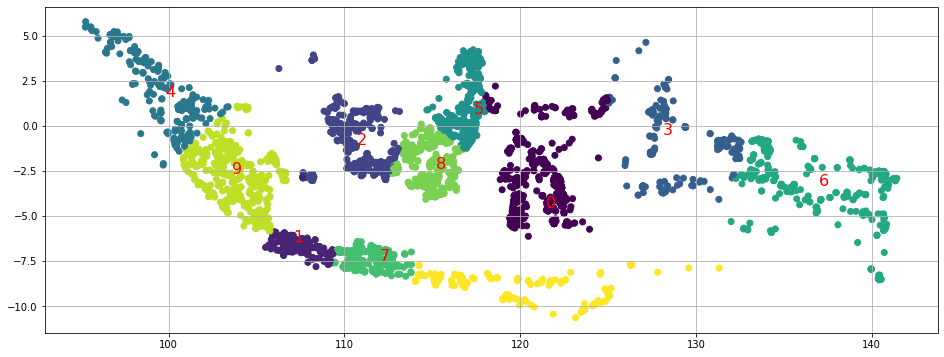

In [7]:
x = merge_dataset_corrected['gps_longitude']
y = merge_dataset_corrected['gps_latitude']
label = cluster_by_geolocation(geo_cluster, Xlonlat)
merge_dataset_corrected['geo_cluster'] = label
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(16,6))
ax.scatter(x,y, c=label)
for i, c in enumerate(geo_cluster.cluster_centers_):
    ax.annotate(i, (c[0], c[1]), color='red', size=16)
ax.grid(which='both')
plt.show()

# Refine Equipment Segmentation

In [8]:
merge_dataset_segmented = merge_dataset_corrected.copy()
merge_dataset_segmented['segment'] = merge_dataset_segmented.apply(equipments_segmentation, axis=1)

In [9]:
segment_size = merge_dataset_segmented.groupby([
    "segment"
])['unit_serial_number'].count().reset_index()
sufficient_segment = segment_size[segment_size['unit_serial_number']>=20]['segment'].tolist()
merge_dataset_clean = merge_dataset_segmented[merge_dataset_segmented['segment'].isin(sufficient_segment)]
merge_dataset_clean.head()

,manufacturer,unit_model,unit_serial_number,local_date,daily_fuel_value,daily_actual_work_value,daily_smr_value,daily_emode,daily_pmode,daily_travel_value,...,gps_datetime,gps_origin,gps_datum,gps_latitude,gps_longitude,industry_sector,plant,customer,geo_cluster,segment
0,KOMATSU,PC400-8,J31289,2019-01-08,1.2,4.0,6.0,0.0,6.0,3.0,...,2019-01-09T01:18:00+07:00,measure,WGS84,-6.149600,106.935433,OTH,NaN,NaN,1,PC400-8_AGR
1,KOMATSU,PC400-8,J31288,2019-01-08,6.0,15.0,24.0,0.0,23.0,10.0,...,2019-01-09T01:23:00+07:00,measure,WGS84,-6.150333,106.934899,OTH,NaN,NaN,1,PC400-8_AGR
2,KOMATSU,PC400-8,J31287,2019-01-08,21.0,47.0,90.0,18.0,56.0,31.0,...,2019-01-09T01:27:00+07:00,measure,WGS84,-6.150266,106.934366,OTH,NaN,NaN,1,PC400-8_AGR
3,KOMATSU,PC400-8,J31286,2019-01-07,20.0,36.0,64.0,29.0,28.0,18.0,...,2019-01-08T01:16:00+07:00,measure,WGS84,-6.149933,106.934600,OTH,NaN,NaN,1,PC400-8_AGR
4,KOMATSU,PC400-8,J31285,2019-01-09,3.6,9.0,28.0,28.0,0.0,7.0,...,2019-01-10T01:29:00+07:00,measure,WGS84,-6.149899,106.934799,AGR,BLP,BINTANG NUSANTARA LINDA,1,PC400-8_AGR


# Fuel Anomaly Classification

In [10]:
komtrax_features = ['daily_actual_work_value', 'daily_smr_value', 'daily_travel_value', 
                    'daily_emode', 'daily_pmode']
category_matrix = \
        np.array([["light","light", "light"],
                  ["moderate","moderate", "moderate"], 
                  ["moderate","moderate", "heavy"]])

In [11]:
category_matrix = \
        np.array([["light","light", "light"],
                  ["moderate","moderate", "moderate"], 
                  ["moderate","moderate", "heavy"]])

fuel_eficiency_indexing_pipeline = Pipeline([
    ('industry_mapping', MapIndustrySector()),
    ('data_type_cleanser', EnsureDataTypes(komtrax_features+['daily_fuel_value'])),
    ('minute_converter', ConvertMinutesToHours(komtrax_features)),
    ('feature_derivator', DeriveFeatures([komtrax_feature_derivator])),
    ('working_behavior_categorizer', WorkingBehaviorCategorization(
        category_matrix=category_matrix, 
        mode_threshold=(-0.6, 0.6), 
        prod_threshold=(0.5, 0.8))),
    ('traveling_hours_examiner', ZTestAnomaly(
        features=['daily_travel_value'], direction='right', threshold=2, min_sample=20)),
    ('fuel_anomaly_detector', FuelAnomalyDetection(
        features=['daily_productivity'], target='fuel_consumption_ratio',
        anomaly_detector=EllipticEnvelope(contamination=0.3),
        regressor=LinearRegression(),
        min_sample=20, 
        anomaly_distance=4)),
    ('value_returner', ColumnSelector(columns=['working_char', 'fuel_index', 'daily_travel_value_anomaly']))
])

In [12]:
training_dataset = merge_dataset_clean.copy()
training_dataset['daily_productivity'] = (training_dataset['daily_actual_work_value']/
                                          training_dataset['daily_smr_value']).astype(float)
training_dataset = training_dataset[
    (training_dataset['daily_productivity']>0.1) &
    (training_dataset['daily_productivity']<=1.1)
]

fn_format = "model/{0}_fuel_efficiency_index_model-latest.pkl"

for segment in sufficient_segment:
    Xtrain = training_dataset[(training_dataset['segment']==segment) ].copy()
    if len(Xtrain)>0:
        fn = fn_format.format(segment)
        pipeline = fuel_eficiency_indexing_pipeline.fit(Xtrain)
        joblib.dump(pipeline, fn)
    print("Finsih training for {}".format(segment))

Finsih training for D155A-6_CON
Finsih training for D155A-6_MNG
Finsih training for PC200-8M0_AGR
Finsih training for PC200-8M0_CON_0
Finsih training for PC200-8M0_CON_1
Finsih training for PC200-8M0_CON_10
Finsih training for PC200-8M0_CON_2
Finsih training for PC200-8M0_CON_3
Finsih training for PC200-8M0_CON_4
Finsih training for PC200-8M0_CON_5
Finsih training for PC200-8M0_CON_6
Finsih training for PC200-8M0_CON_7
Finsih training for PC200-8M0_CON_8
Finsih training for PC200-8M0_CON_9
Finsih training for PC200-8M0_FOR
Finsih training for PC200-8M0_MNG
Finsih training for PC200-8_AGR
Finsih training for PC200-8_CON_0
Finsih training for PC200-8_CON_1
Finsih training for PC200-8_CON_10
Finsih training for PC200-8_CON_2
Finsih training for PC200-8_CON_3
Finsih training for PC200-8_CON_4
Finsih training for PC200-8_CON_5
Finsih training for PC200-8_CON_6
Finsih training for PC200-8_CON_7
Finsih training for PC200-8_CON_8
Finsih training for PC200-8_CON_9
Finsih training for PC200-8_FO

In [26]:
len(training_dataset)

6951

# Visualize Classification

PC200-8_CON_0 180
PC200-8_CON_1 114
PC200-8_CON_10 27
PC200-8_CON_2 36
PC200-8_CON_3 82
PC200-8_CON_4 45
PC200-8_CON_5 116
PC200-8_CON_6 92
PC200-8_CON_7 75
PC200-8_CON_8 70
PC200-8_CON_9 135


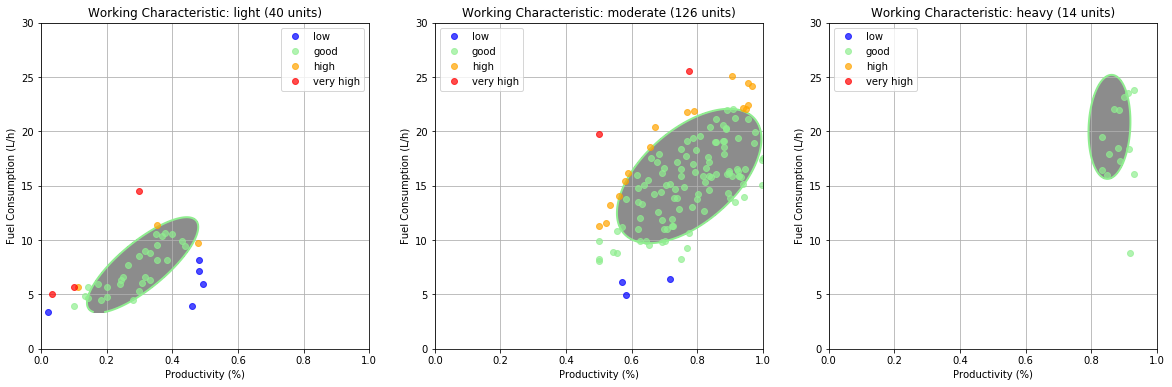

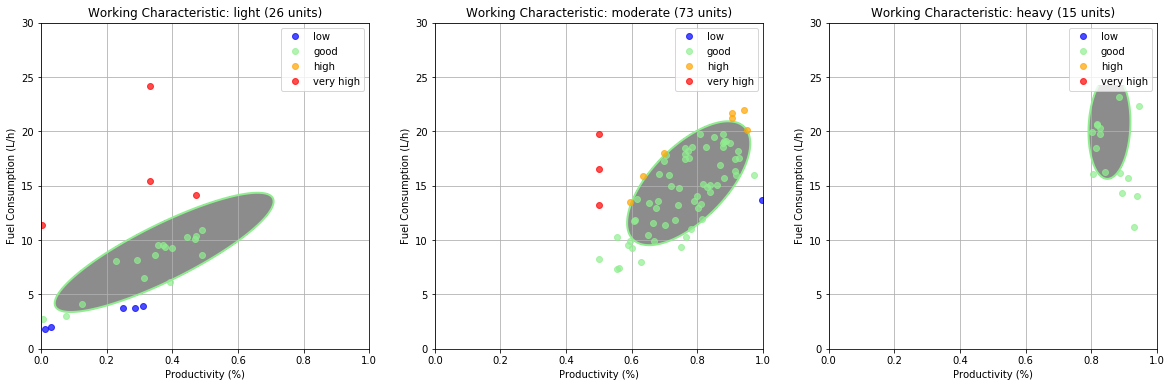

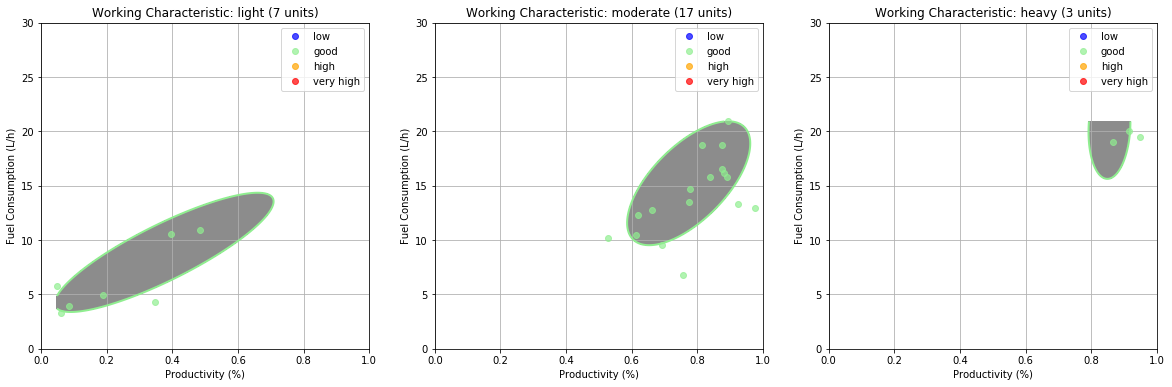

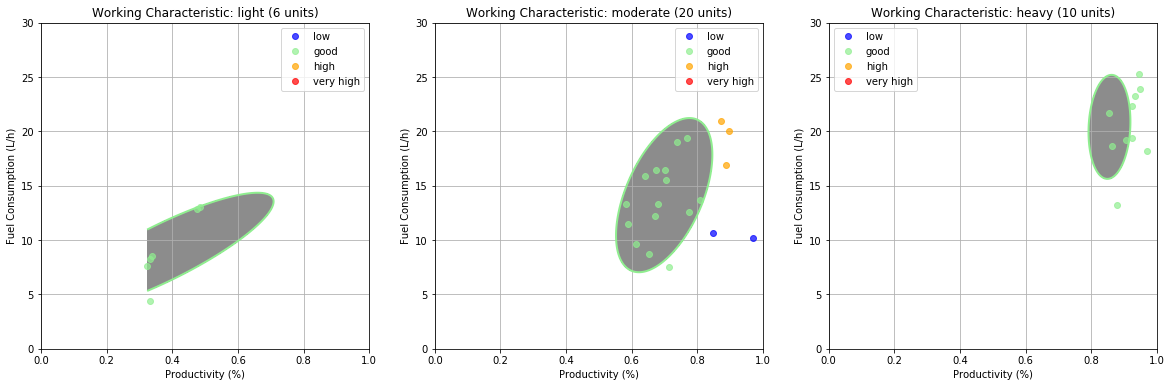

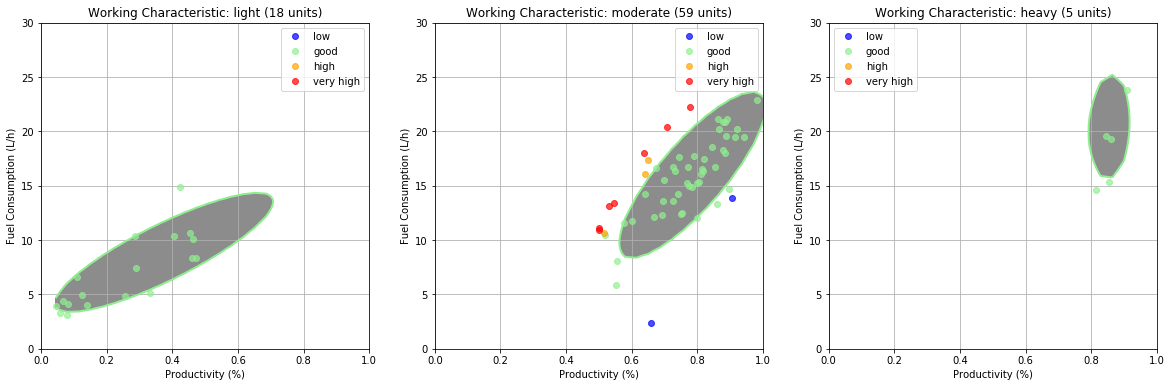

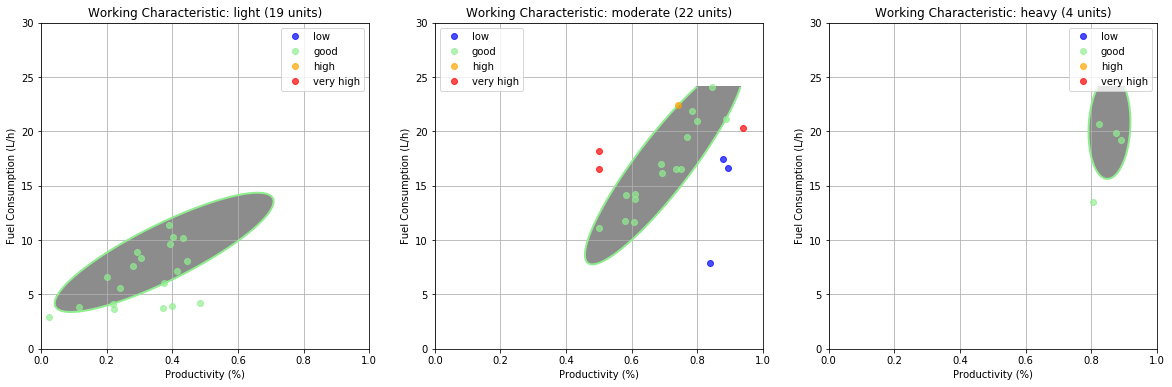

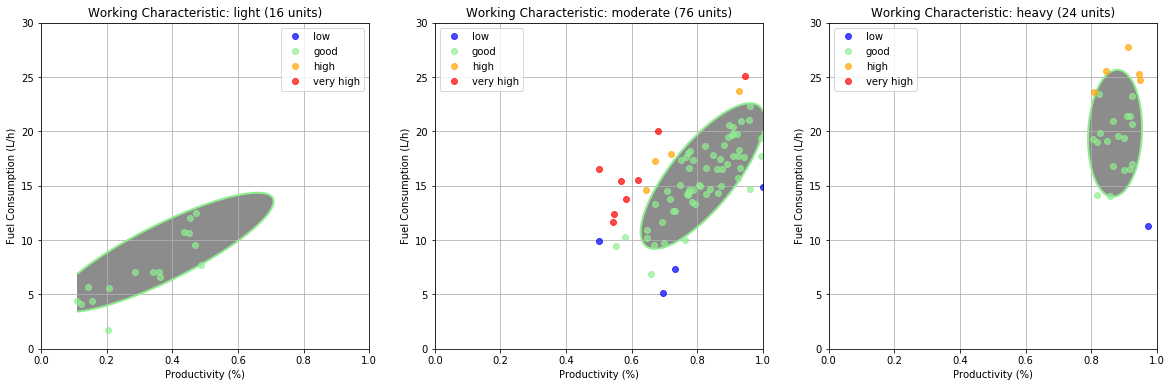

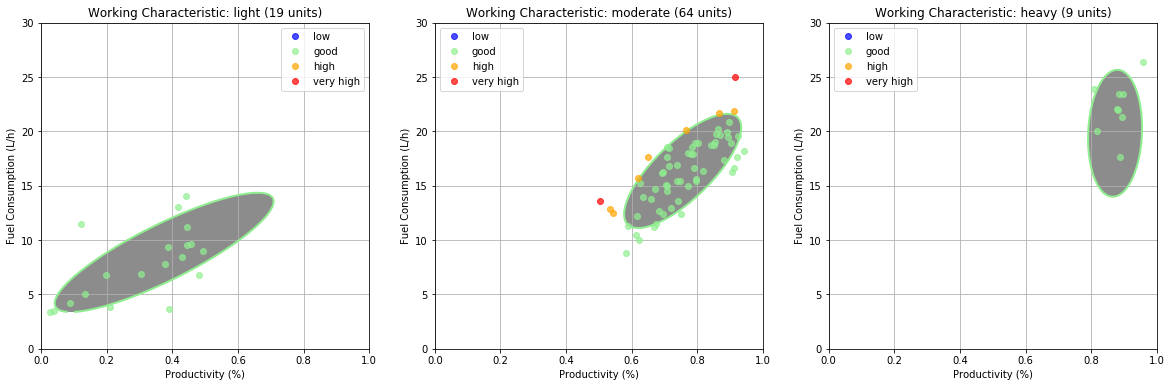

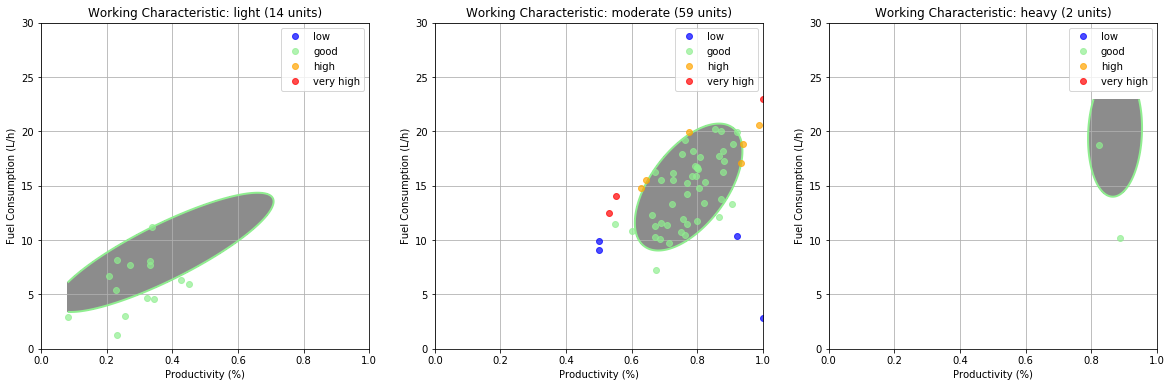

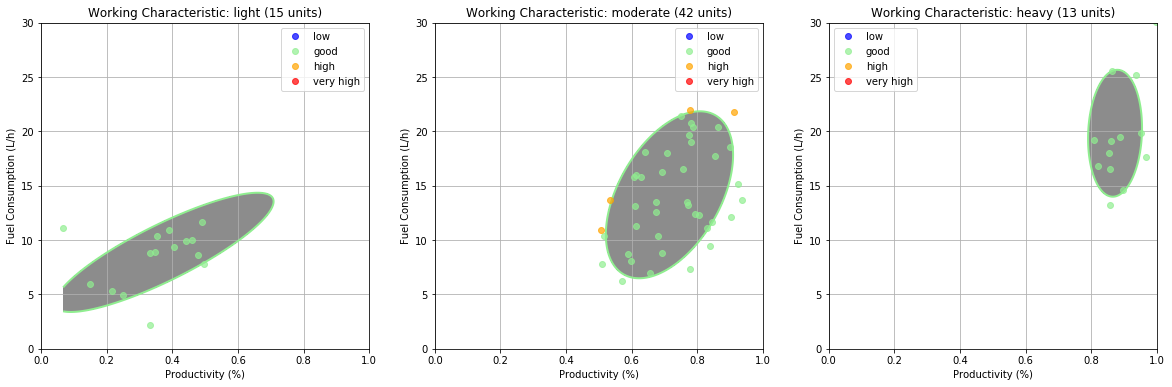

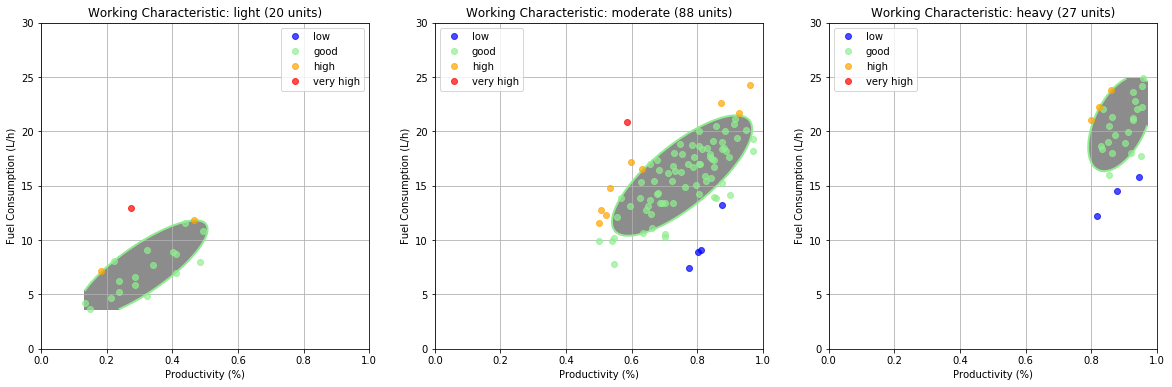

In [13]:
unit_model = 'PC200-8'
sector = 'CON'
geo_cluster_model = joblib.load("geo_location_clustering.pkl")

training_dataset = merge_dataset_clean.copy()
sample = training_dataset[
    (training_dataset['unit_model']==unit_model) &
    (training_dataset['industry_sector']==sector)].copy()
sample['geo_cluster'] = cluster_by_geolocation(geo_cluster_model, sample[['gps_longitude', 'gps_latitude']].values)
sample['segment'] = sample.apply(equipments_segmentation, axis=1)
sample = sample.sort_values('segment')
segment_collection = []
for segment in (sample['segment'].drop_duplicates().tolist()):
    model_file = "model/{}_fuel_efficiency_index_model-latest.pkl".format(segment)
    pipeline = joblib.load(model_file)
    sample_segment = sample[sample['segment']==segment].copy()
    print(segment, len(sample_segment))
    segment_collection.append(sample_segment)
    result = pipeline.transform(sample_segment)
    sample_segment['fuel_index'] = result[:,1]
    xaxis = 'daily_productivity'
    yaxis = 'fuel_consumption_ratio'

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    for i, cat in enumerate(['light', 'moderate', 'heavy']):
        ax = axes[i]
        X = sample_segment[sample_segment['working_char']==cat].copy()    

        label = ['low', 'good', 'high', 'very high']
        col = ['blue', 'lightgreen', 'orange', 'red']
        for c,j in zip(col, label):
            ax.plot(
                X[X['fuel_index']==j][xaxis],
                X[X['fuel_index']==j][yaxis],
                'o', label=j, alpha=0.7, c=c
            )
        ax.legend()
        xx, yy = np.meshgrid(
            np.linspace(sample_segment[xaxis].min(), sample_segment[xaxis].max(), 500), 
            np.linspace(sample_segment[yaxis].min(), sample_segment[yaxis].max(), 500))
        try:
            anomaly_detector = pipeline.steps[6][-1].anomaly_detector
            Z = anomaly_detector[i].decision_function(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            a = ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='lightgreen')
            ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='gray', alpha=0.9)
        except:
            pass
        ax.grid(True)
        ax.set_title("Working Characteristic: {} ({} units)".format(cat, len(X)))
        ax.set_ylim([0, 30])
        ax.set_xlim([0,1])
        ax.set_xlabel('Productivity (%)')
        ax.set_ylabel('Fuel Consumption (L/h)')

# Scoring Script

In [31]:
data = read_data_from_json('sample_input_3.json')
result_data = classify_fuel_consumption(data)

In [36]:
result_data = pd.DataFrame(result_data)
input_data = pd.DataFrame(data)

In [43]:
output_data = input_data.join(result_data[["segment","geo_cluster", "fuel_consumption_index"]])
output_data = output_data.set_index(["unit_model", "unit_serial_number", "local_date", "segment"]).reset_index()
output_data.to_csv("fuel_consumption_index_output_data.csv", index=False)

# Prepare Testing Data

data = dict(
    training_dataset.sample(frac=1).reset_index(drop=True)\
    [['local_date', 'industry_sector','unit_model','unit_serial_number', 
      'daily_fuel_value', 'gps_latitude', 'gps_longitude']+komtrax_features]\
    .reset_index(drop=True).loc[0])
write_data_to_json(stringify_dict(data), 'sample_input_1.json')

data = \
    training_dataset.sample(frac=1).reset_index(drop=True)\
    [['local_date', 'industry_sector','unit_model','unit_serial_number', 
      'daily_fuel_value', 'gps_latitude', 'gps_longitude']+komtrax_features]\
    .reset_index(drop=True).loc[[0,1,2]].to_dict('records')
write_data_to_json(stringify_dict(data), 'sample_input_2.json')

In [27]:
data = \
    training_dataset.sample(frac=1).reset_index(drop=True)\
    [['local_date', 'industry_sector','unit_model','unit_serial_number', 
      'daily_fuel_value', 'gps_latitude', 'gps_longitude']+komtrax_features]\
    .reset_index(drop=True).to_dict('records')
write_data_to_json(stringify_dict(data), 'sample_input_3.json')

# ------------------------- End Here ---------------------------